In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/


In [2]:
!kaggle datasets download -d salader/dogs-vs-cats

Dataset URL: https://www.kaggle.com/datasets/salader/dogs-vs-cats
License(s): unknown
 99% 1.05G/1.06G [00:08<00:00, 262MB/s]
100% 1.06G/1.06G [00:09<00:00, 127MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [33]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten,BatchNormalization,Dropout
from keras.layers import RandomFlip, RandomRotation, RandomZoom

Generators are used to process a large number of *datas*

In [5]:
# generators
train_ds = keras.utils.image_dataset_from_directory(
    directory='/content/train',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(256, 256)
)
validation_ds = keras.utils.image_dataset_from_directory(
    directory='/content/test',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(256, 256)
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


Normalize to transform all pixels values between 0 and 1.

In [6]:
# # Normalize
# def process(image, label):
#   image = tf.cast(image/255. , tf.float32)
#   return image, label

# train_ds = train_ds.map(process)
# validation_ds = validation_ds.map(process)


In [61]:
import tensorflow as tf

# Normalize and Invert Labels
def process(image, label):
  image = tf.cast(image / 255.0, tf.float32)
  # Invert the label: if label was 0 (cat), make it 1. If label was 1 (dog), make it 0.
  inverted_label = 1 - label
  return image, inverted_label

# Apply the modified process function to your datasets
train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

In [34]:
data_augmentation = keras.Sequential(
    [
        RandomFlip("horizontal"),  # Randomly flip images horizontally
        RandomRotation(0.1),       # Randomly rotate images by up to 10% of 2*pi radians
        RandomZoom(0.1),           # Randomly zoom images in or out by up to 10%
    ]
)

Three convolution layers ,where 1st layer has 32 filters ,2nd layer has 64 and the 3rd layer has 128 filters

In [35]:
# # create CNN model

# model = Sequential()


# model.add(Conv2D(32,kernel_size=(3,3),padding='valid', activation='relu', input_shape=(256,256,3)))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

# model.add(Conv2D(64,kernel_size=(3,3),padding='valid', activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

# model.add(Conv2D(128,kernel_size=(3,3),padding='valid', activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(2,2), strides=2, padding='valid'))

# model.add(Flatten())

# model.add(Dense(128, activation='relu'))
# model.add(Dropout(0.1))
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.1))
# model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [43]:
# create CNN model
model = Sequential()

# Add the data augmentation layers as the first layers of the model
# These layers are active only during training
model.add(data_augmentation)

# Add a Rescaling layer to normalize pixel values to [0, 1]
# This is crucial for most deep learning models
# model.add(keras.layers.Rescaling(1./255))


# Your existing convolutional and dense layers
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [44]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │    29,491,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,585,985 (112.86 MB)

 Trainable params: 29,585,473 (112.86 MB)

 Non-trainable params: 512 (2.00 KB)

In [45]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [46]:
history = model.fit(train_ds,epochs=10,validation_data=validation_ds)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 59s 91ms/step - accuracy: 0.5988 - loss: 0.7093 - val_accuracy: 0.7140 - val_loss: 0.5594
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 56s 90ms/step - accuracy: 0.7140 - loss: 0.5615 - val_accuracy: 0.6864 - val_loss: 0.6018
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 78s 84ms/step - accuracy: 0.7648 - loss: 0.4948 - val_accuracy: 0.7854 - val_loss: 0.4654
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 52s 83ms/step - accuracy: 0.7810 - loss: 0.4686 - val_accuracy: 0.7464 - val_loss: 0.5165
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 86s 90ms/step - accuracy: 0.7945 - loss: 0.4475 - val_accuracy: 0.7804 - val_loss: 0.4614
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 56s 89ms/step - accuracy: 0.8058 - loss: 0.4229 - val_accuracy: 0.8194 - val_loss: 0.3955
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 52s 83ms/step - accuracy: 0.8157 - loss: 0.4056 - val_accuracy: 0.7738 - val_loss: 0.5134
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 56s 90ms/step - accuracy: 0.8236 - loss: 0.3939 - 

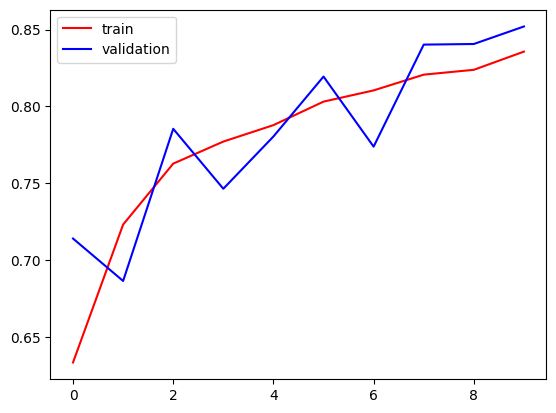

In [47]:
import matplotlib.pyplot as plt

plt.plot(model.history.history['accuracy'], color='red', label='train')
plt.plot(model.history.history['val_accuracy'], color='blue', label='validation')
plt.legend()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

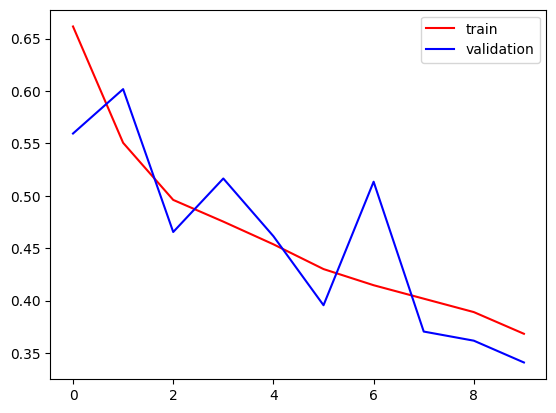

In [48]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show

In [62]:
# Assuming 'history' is the object returned by model.fit()
final_val_accuracy = history.history['val_accuracy'][-1]
print(f"Final Validation Accuracy: {final_val_accuracy:.4f}")

# To convert it to a score out of 100:
score_out_of_100 = final_val_accuracy * 100
print(f"Score out of 100: {score_out_of_100:.2f}")

Final Validation Accuracy: 0.8520
Score out of 100: 85.20


Overfitting occurs

Ways tor reduce overfitting

Add more data

Data Augmentation

L1/L2 Regularizer

Dropout

Batch Norm

Reduce complexity

Now ,I will test the model whether it can predict correctly or not.

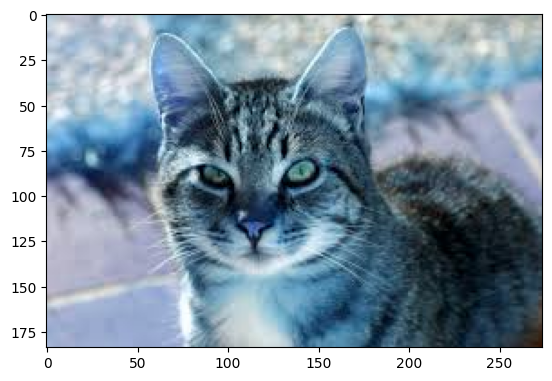

In [63]:
import cv2
import matplotlib.pyplot as plt
import os # Import the os module to list directory contents


# Replace 'some_image_file.jpg' with an actual image file name from the directory
image_file_path = '/content/cat.jpeg' # Example: assuming dog.1.jpg exists

test_image = cv2.imread(image_file_path)

# Check if the image was loaded successfully
if test_image is not None:
    plt.imshow(test_image)
    plt.show() # Add plt.show() to display the image
else:
    print(f"Error: Could not load the image at {image_file_path}. Please check the file path.")

In [64]:
test_image.shape

(184, 274, 3)

In [65]:
test_image = cv2.resize(test_image,(256,256))

In [67]:
test_input=test_image.reshape((1,256,256,3))

In [68]:
model.predict(test_input)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


array([[1.]], dtype=float32)